In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem

import os
import glob
import h5py
import tqdm
import json
import pickle
from collections import namedtuple, Counter
from pathlib import Path

### PARAMETERS

In [2]:
agent_name = "handcrafted"
runs_folder = "./runs/handcrafted/valkyrie"

### Setup

In [3]:
stat_names = "x y strength_percentage strength dexterity constitution intelligence wisdom charisma score hitpoints max_hitpoints depth gold energy max_energy armor_class monster_level experience_level experience_points time hunger_state carrying_capacity dungeon_number level_number prop_mask alignment"
trajectory_files = glob.glob(os.path.join(runs_folder, "*", "trajectories.h5py"))
print(f"Found {len(trajectory_files)} trajectories")
assert len(trajectory_files) != 0

os.makedirs(f"./{agent_name}", exist_ok=True)

def log_path(file_name):
    return f"./{agent_name}/{file_name}"

Found 100 trajectories


In [4]:
blstats = []
for path in tqdm.tqdm(trajectory_files, desc="Loading data..."):
    try:
        with h5py.File(path) as file:
            trajectory_groups = file["trajectories"]
            assert len(trajectory_groups) == 1, "Expected only one trajectory per run"
            trajectory = trajectory_groups["0"]       

            blstats.append(trajectory["observations"]["blstats"][:,:])
    except:
        print(f"Failed to read {path}")

Loading data...:   0%|          | 0/100 [00:00<?, ?it/s]

Loading data...:  12%|█▏        | 12/100 [00:00<00:00, 112.58it/s]

Failed to read ./runs/handcrafted/valkyrie/139364/trajectories.h5py
Failed to read ./runs/handcrafted/valkyrie/180696/trajectories.h5py


Loading data...:  70%|███████   | 70/100 [00:00<00:00, 137.07it/s]

Failed to read ./runs/handcrafted/valkyrie/502728/trajectories.h5py
Failed to read ./runs/handcrafted/valkyrie/64480/trajectories.h5py


Loading data...: 100%|██████████| 100/100 [00:00<00:00, 136.78it/s]

Failed to read ./runs/handcrafted/valkyrie/771548/trajectories.h5py
Failed to read ./runs/handcrafted/valkyrie/81965/trajectories.h5py
Failed to read ./runs/handcrafted/valkyrie/88750/trajectories.h5py


In [5]:
# The last timestep is sometimes all zeroes, seems like saving it didn't work properly
# So we just remove it
_dfs = [pd.DataFrame(data=b[:-1], columns=stat_names.split(" ")).reset_index(names="timestep") for b in blstats]
_dfs = [df.melt(value_name="value", var_name="stat", id_vars="timestep") for df in _dfs]
for i, df in enumerate(_dfs):
    df["run_id"] = os.path.basename(Path(trajectory_files[i]).parent)

blstats_df = pd.concat(_dfs, ignore_index=True)
blstats_df.sample(n=10)

,timestep,stat,value,run_id
2019332,493,gold,0,64480
2374398,1182,depth,1,746130
2509807,646,y,15,765212
626141,659,prop_mask,0,300345
2278661,207,time,193,71835
2760903,65,max_hitpoints,18,835941
366191,1668,y,6,209279
2721991,1250,monster_level,0,81965
2080808,56,intelligence,10,697100
2366521,1665,charisma,8,746130


# Progress across all runs

In [6]:
max_stats = blstats_df.groupby(["run_id", "stat"])["value"].max().reset_index()
results_summary = max_stats.groupby("stat")["value"].agg(["mean", "std", "var", "median", "min", "max"]).reset_index()
results_summary.to_csv(f"./{agent_name}/progress.csv", sep=";")
results_summary[results_summary["stat"].isin(["score", "depth", "experience_level", "time"])].reset_index(drop=True)

,stat,mean,std,var,median,min,max
0,depth,2.354839,0.928359,0.861851,2.0,1,5
1,experience_level,2.387097,1.053279,1.109397,3.0,1,5
2,score,250.236559,159.170363,25335.204301,218.0,0,912
3,time,1306.408602,924.166207,854083.179056,1075.0,2,5482


# Frequency of reached depth & experience level

In [7]:
df = blstats_df[blstats_df['stat'].isin(["level_number", "experience_level"])]
df = df.drop_duplicates(subset=["stat", "value", "run_id"])
df = df.groupby("stat")["value"].value_counts().reset_index().sort_values(["stat", "value"])
df = df[df["value"] != 0] # The blstats of the last timestep is 0, probably due to the environment ending?
df["frequency"] = df["count"] / len(trajectory_files)
df.to_csv(log_path("progress_frequency.csv"), sep=";")
df

,stat,value,count,frequency
0,experience_level,1,93,0.93
1,experience_level,2,67,0.67
2,experience_level,3,49,0.49
3,experience_level,4,12,0.12
4,experience_level,5,1,0.01
5,level_number,1,93,0.93
6,level_number,2,79,0.79
7,level_number,3,27,0.27
8,level_number,4,11,0.11
9,level_number,5,2,0.02


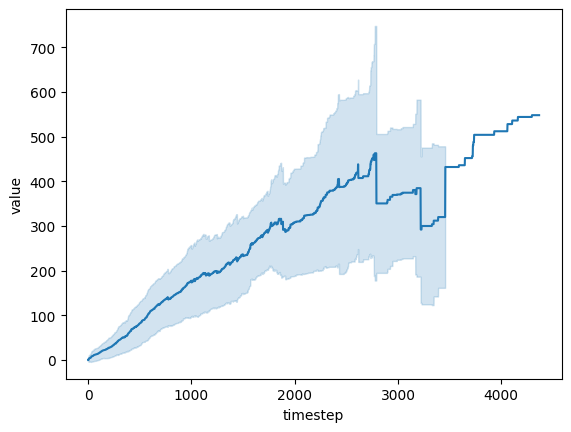

In [8]:
sns.lineplot(x='timestep', y='value', errorbar='sd', data=blstats_df[blstats_df['stat'] == 'score'])
plt.savefig(log_path("score_lineplot.png"))

# Visualize Message Embeddings

In [31]:
embeddings_file = os.path.join(runs_folder, "message_embeddings.pkl")
try:
    with open(embeddings_file, "rb") as f:
        embeddings = pickle.load(f)

    embedding_messages = np.array([e["message"][0] for e in embeddings])
    message_counts = [e["count"] for e in embeddings]
    embeddings_arr = np.array([e["embedding"] for e in embeddings])

    print(f"Found {len(embedding_messages)} messages")
    print(f"Embeddings array shape: {embeddings_arr.shape}")
except:
    print(f"Failed to read {embeddings_file}")

Found 2404 messages
Embeddings array shape: (2404, 768)


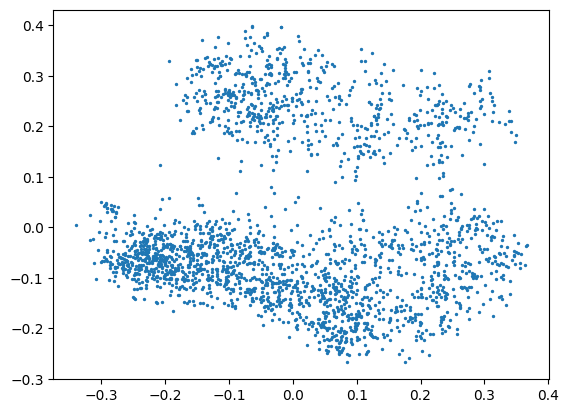

In [10]:
if embeddings:
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA
    from sklearn import cluster

    pca = PCA(n_components=2)
    transformed = pca.fit_transform(embeddings_arr)
    
    #local_k_means = cluster.KMeans(n_clusters=8, random_state=42)
    #local_k_means.fit(transformed_df)
    #preds = local_k_means.predict(transformed_df)
    
    plt.scatter(transformed[:,0], transformed[:,1], s=2)
    #plt.title(f"Clusters from {n}-PCA-Embedding")
    plt.show()

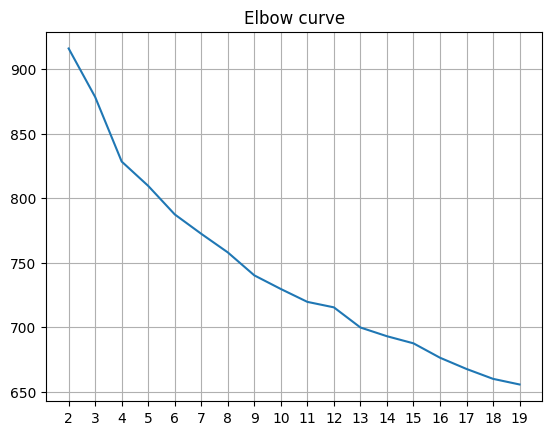

In [14]:
distorsions = []
ks = list(range(2,20))
for k in ks:
    kmeans = cluster.KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(embeddings_arr)
    distorsions.append(kmeans.inertia_)

fig = plt.figure()
plt.plot(ks, distorsions)
plt.xticks(ks)
plt.grid(True)
plt.title('Elbow curve')

kmeans = cluster.KMeans(n_clusters=4, random_state=42, n_init="auto")
predictions = kmeans.fit_predict(embeddings_arr)

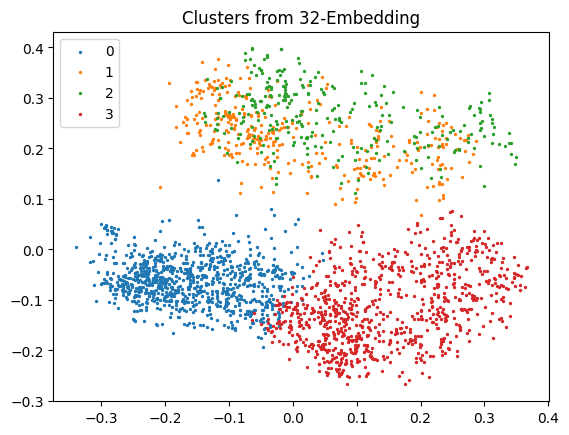

In [40]:
for i in range(4):
    indices = predictions == i
    plt.scatter(transformed[indices][:,0], transformed[indices][:,1], label=i, s=2)
plt.legend()
plt.title(f"Clusters from 32-Embedding")
plt.show()

In [47]:
np.random.choice(embedding_messages[predictions == 3], size=20)

array(['You miss the giant rat.  The giant rat bites!',
       'You miss the kobold zombie.  The gecko bites!',
       'You hit the iguana!  The iguana bites!', 'You hit the rock mole!',
       'You kill the cave spider!',
       "You kill the acid blob!  You are splashed by the acid blob's acid!--More--",
       'The jackal misses!',
       'The hobbit throws a dagger!  You are almost hit by a dagger.',
       'You kill the grid bug!  The newt misses!',
       'You faint from lack of food.  The large kobold throws a dart!--More--',
       'You miss the gnome.', 'You kill the kobold!',
       'The goblin throws a knife!  A knife misses you.',
       'You kill the acid blob!  Welcome to experience level 3.',
       'You hit Manlobbi!  Manlobbi zaps a wand of striking!--More--',
       'The homunculus bites!',
       'A cloud of gas puts you to sleep!  The jackal bites!--More--',
       'You hit the kobold zombie.  The kobold zombie hits!',
       'The magic missile hits you!  Valkyrie i

# Skill distribution

In [ ]:
prompts = glob.glob(os.path.join(runs_folder, "**", "*_choose_skill_prompt.json"), recursive=True)
print(f"Found {len(prompts)} prompts")
assert len(prompts) != 0

Found 0 prompts


AssertionError: 

In [ ]:
prompt_jsons = []
for path in tqdm.tqdm(prompts, desc="Loading prompts..."):
    with open(path) as f:
        prompt_jsons.append(json.load(f))

Loading prompts...: 100%|██████████| 2343/2343 [00:07<00:00, 305.86it/s]


In [ ]:
skill_names = []
for prompt in prompt_jsons:
    try:
        response = json.loads(prompt["response"])
        skill_names.append(response["skill"]["name"])
    except:
        # The LLM made a mistake
        pass

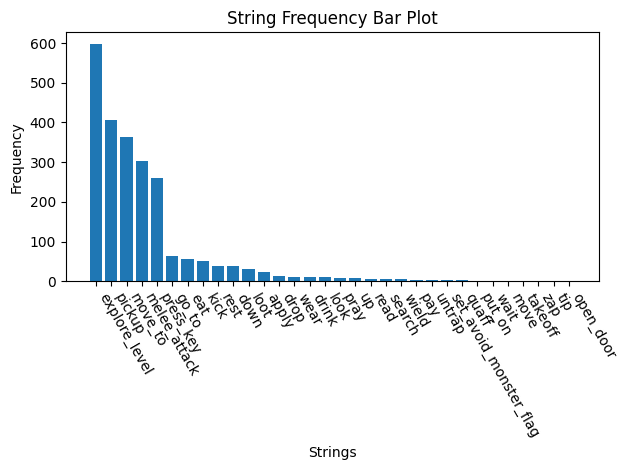

In [ ]:
# Count the occurrences of each string
counter = Counter(skill_names)

# Extract the strings and their frequencies
strings = list(counter.keys())
frequencies = list(counter.values())

# Sort by frequency
sorted_indices = sorted(range(len(frequencies)), key=lambda k: frequencies[k], reverse=True)
strings = [strings[i] for i in sorted_indices]
frequencies = [frequencies[i] for i in sorted_indices]

# Create a bar plot with rotated strings
plt.bar(strings, frequencies)
plt.xlabel('Strings')
plt.ylabel('Frequency')
plt.title('String Frequency Bar Plot')
plt.xticks(rotation=-60, ha='left')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.savefig(log_path("skill_distribution.png"))

# Tokens

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import AIMessage, HumanMessage, SystemMessage

def create_message(type, content):
    if type == "ai":
        return AIMessage(content=content)
    if type == "human":
        return HumanMessage(content=content)
    if type == "system":
        return SystemMessage(content=content)
    
    assert False

llm = ChatOpenAI(model="gpt-4-1106-preview")

token_data = []
for path, json in zip(prompts, prompt_jsons):
    context = [create_message(*list(list(c.items())[0])) for c in json["context"]]
    prompt = create_message("system", json["prompt"])
    response = create_message("ai", json["response"])

    run_id = os.path.basename(Path(path).parent.parent)
    timestep = os.path.basename(Path(path).parent)
    token_data.append({
        "run_id": run_id, 
        "timestep": int(timestep), 
        "prompt_tokens": llm.get_num_tokens_from_messages([*context, prompt]),
        "response_tokens": llm.get_num_tokens_from_messages([response])
    })

token_df = pd.DataFrame(token_data)
#token_df = pd.merge(blstats_df, token_df, how="left", on=["run_id", "timestep"]).fillna(0)

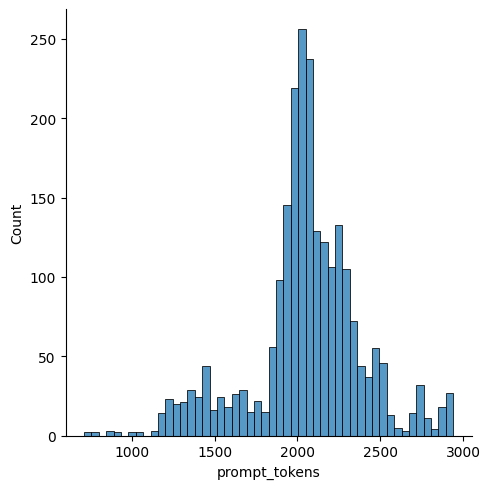

In [ ]:
sns.displot(data=token_df, x="prompt_tokens", kde=False, stat="count")
plt.savefig(log_path("prompt_token_dist.png"))

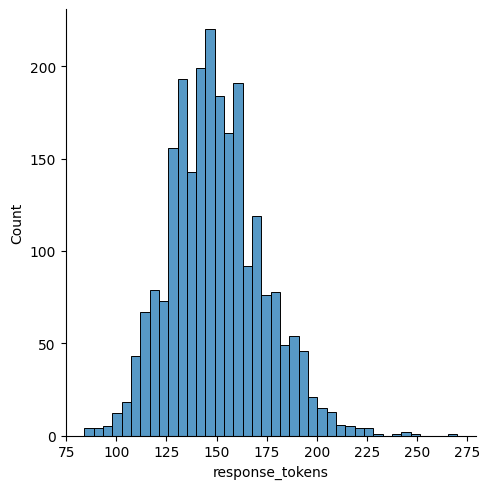

In [ ]:
sns.displot(data=token_df, x="response_tokens", kde=False, stat="count")
plt.savefig(log_path("response_token_dist.png"))

In [ ]:
# Compute the cumulative sum ordered by 'timestep' for each 'run_id'
token_df.sort_values(by=['run_id', 'timestep'], inplace=True)
token_df['cumulative_prompt_tokens'] = token_df.groupby('run_id')['prompt_tokens'].cumsum()
token_df['cumulative_response_tokens'] = token_df.groupby('run_id')['response_tokens'].cumsum()

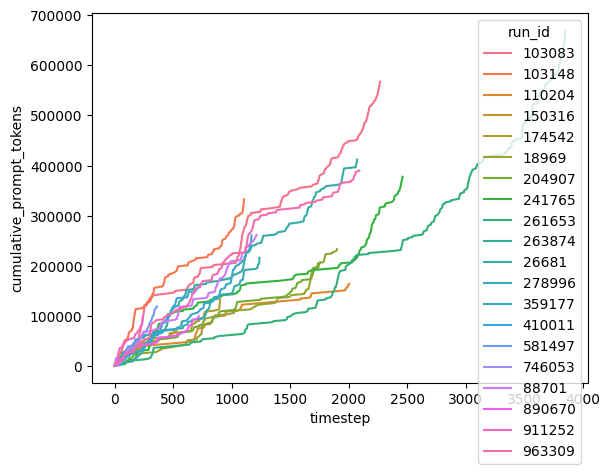

In [ ]:
sns.lineplot(x='timestep', y='cumulative_prompt_tokens', hue="run_id", data=token_df)
plt.savefig(log_path("cumulative_prompt_tokens.png"))

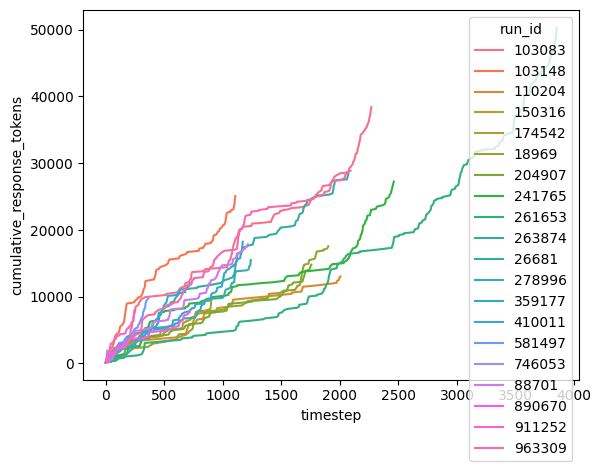

In [ ]:
sns.lineplot(x='timestep', y='cumulative_response_tokens', hue="run_id", data=token_df)
plt.savefig(log_path("cumulative_response_tokens.png"))